<a href="https://colab.research.google.com/github/gcunharodrigues/fcc_predict_health_costs/blob/main/fcc_predict_health_costs_with_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries. You may or may not use all of these.
!pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

  Preparing metadata (setup.py) ... done
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
# Import data
!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
dataset = pd.read_csv('insurance.csv')
dataset.tail()

--2025-01-29 16:32:46--  https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.3.33, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50264 (49K) [text/csv]
Saving to: ‘insurance.csv.1’

insurance.csv.1     100%[===================>]  49.09K  --.-KB/s    in 0.001s  

2025-01-29 16:32:46 (32.4 MB/s) - ‘insurance.csv.1’ saved [50264/50264]



,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


In [ ]:
# Dataset info
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [ ]:
# Check missing and NaN
dataset.isna().sum()

,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
expenses,0


In [ ]:
# Check duplicates
dataset[dataset.duplicated(keep=False)]

,age,sex,bmi,children,smoker,region,expenses
195,19,male,30.6,0,no,northwest,1639.56
581,19,male,30.6,0,no,northwest,1639.56


In [ ]:
# Clean dataset
dataset = dataset.drop_duplicates().reset_index(drop=True)

In [ ]:
# Some statistical data
dataset.groupby(['region', 'smoker','sex']).agg(['mean','std', 'count'])

age                         bmi            \
                              mean        std count       mean       std   
region    smoker sex                                                       
northeast no     female  39.840909  14.362711   132  29.783333  6.062514   
                 male    39.216000  14.209029   125  28.859200  5.635817   
          yes    female  38.724138  12.492559    29  27.272414  7.231671   
                 male    37.868421  14.121425    38  29.563158  5.185344   
northwest no     female  39.755556  14.101692   135  29.486667  5.425875   
                 male    38.717557  13.805392   131  28.922901  5.039651   
          yes    female  38.827586  14.469349    29  28.303448  4.833254   
                 male    39.827586  14.871038    29  29.986207  4.558879   
southeast no     female  39.071942  14.093189   139  32.780576  5.901828   
                 male    38.261194  14.374648   134  34.133582  6.639356   
          yes    female  39.250000  14.713211    36  32.258333  6.821662   
                 male    40.054545  13.761753    55  33.656364  7.153936   
southwest no     female  40.099291  13.692180   141  30.050355  5.666375   
                 male    40.277778  14.237774   126  31.019841  5.832489   
          yes    female  37.047619  16.073196    21  30.128571  6.530937   
                 male    35.567568  12.431011    37  31.502703  4.704046   

                               children                      expenses  \
                        count      mean       std count          mean   
region    smoker sex                                                    
northeast no     female   132  0.954545  1.131530   132   9640.427121   
                 male     125  1.144000  1.330195   125   8664.042640   
          yes    female    29  1.241379  0.987608    29  28032.045517   
                 male      38  0.894737  1.109893    38  30926.252895   
northwest no     female   135  1.177778  1.208593   135   8786.998519   
                 male     131  1.068702  1.089748   131   8371.690153   
          yes    female    29  0.827586  1.136064    29  29670.824828   
                 male      29  1.724138  1.250616    29  30713.180690   
southeast no     female   139  1.079137  1.210251   139   8440.205396   
                 male     134  1.052239  1.222085   134   7609.003731   
          yes    female    36  0.944444  1.169724    36  33034.821389   
                 male      55  1.036364  0.999326    55  36029.839636   
southwest no     female   141  1.134752  1.260498   141   8234.091702   
                 male     126  1.119048  1.299890   126   7778.906111   
          yes    female    21  1.047619  1.283596    21  31687.988571   
                 male      37  1.297297  1.288084    37  32598.863784   

                                             
                                  std count  
region    smoker sex                         
northeast no     female   6295.694275   132  
                 male     5991.756301   125  
          yes    female  12977.377916    29  
                 male    10412.651349    38  
northwest no     female   5863.079724   135  
                 male     6400.062899   131  
          yes    female  10831.700246    29  
                 male    12137.349007    29  
southeast no     female   6373.624274   139  
                 male     5876.070037   134  
          yes    female  11546.037129    36  
                 male    11123.442284    55  
southwest no     female   5666.931649   141  
                 male     5296.100684   126  
          yes    female  12336.144612    21  
                 male    10782.405894    37

In [ ]:
# Create an input pipeline
def df_to_dataset(dataframe, shuffle=True, batch_size=32, target='target'):
  df = dataframe.copy()
  labels = df.pop(target)
  df = {key: value.to_numpy()[:,tf.newaxis] for key, value in df.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [ ]:
# Create Keras preprocessing layers
# Numerical columns
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

# Categorical columns
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a layer that turns strings into integer indices.
  if dtype == 'string':
    index = layers.StringLookup(max_tokens=max_tokens)
  # Otherwise, create a layer that turns integer values into integer indices.
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens)

  # Prepare a `tf.data.Dataset` that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Encode the integer indices.
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  return lambda feature: encoder(index(feature))

In [ ]:
# Split train and test data
train, test = np.split(dataset.sample(frac=1), [int(.8*len(dataset))])
print(len(train), 'train examples')
print(len(test), 'test examples')

1069 train examples
268 test examples


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [ ]:
# Create training and test dataset
batch_size = 5
train_ds = df_to_dataset(train, batch_size=batch_size, target='expenses')
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size, target='expenses')

In [ ]:
# Numerical and categorical features
num_features = ['age', 'bmi', 'children']
cat_features = ['sex', 'smoker', 'region']

In [ ]:
# List to input in the model
all_inputs = {}
encoded_features = []

In [ ]:
# Preprocess numerical features
for header in num_features:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs[header] = numeric_col
  encoded_features.append(encoded_numeric_col)

# Preprocess categorical features
for header in cat_features:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(header, train_ds, dtype='string')
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs[header] = categorical_col
  encoded_features.append(encoded_categorical_col)

In [ ]:
# Concatenate all encoded
all_features = tf.keras.layers.concatenate(encoded_features)

# Create model
x = tf.keras.layers.Dense(128, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(32, activation="relu")(x)

output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=["mae", 'mse'],
              run_eagerly=True)

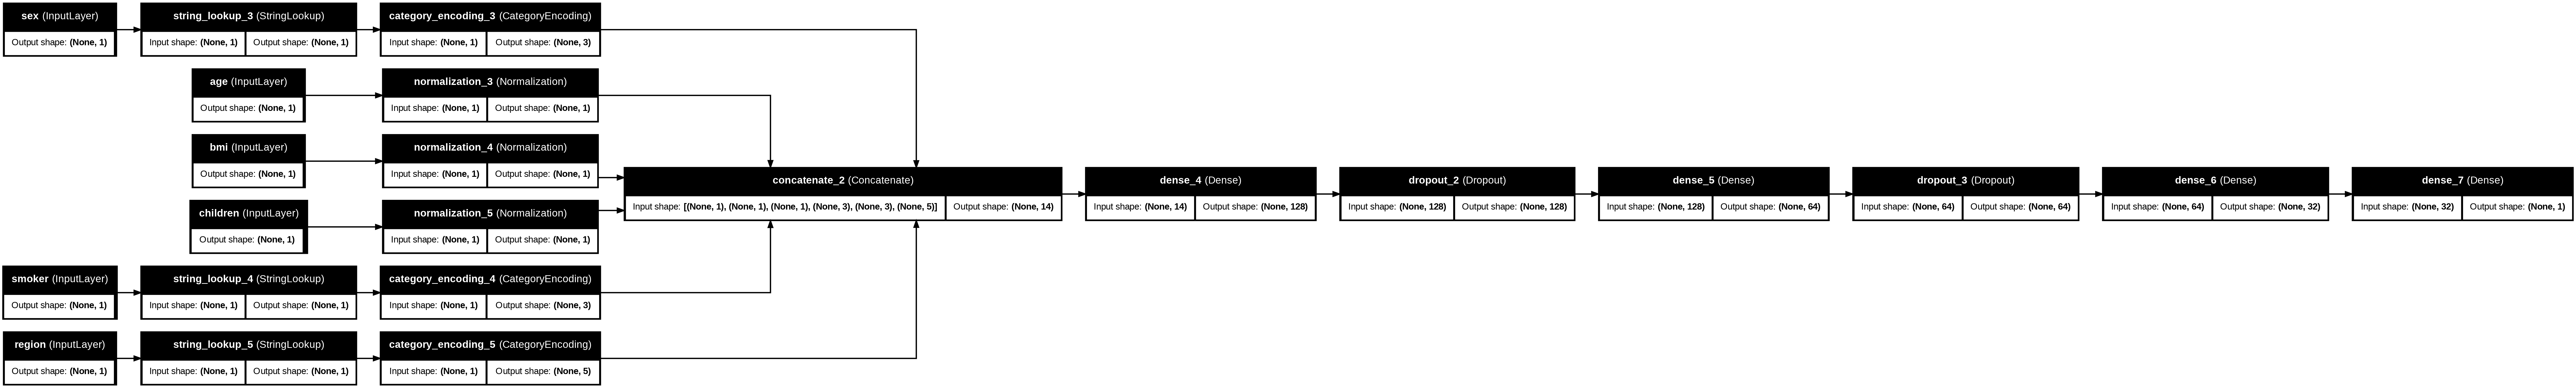

In [ ]:
# Connectivity graph
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, rankdir="LR")

In [ ]:
# Model training
model.fit(train_ds, epochs=20)

Epoch 1/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 19s 87ms/step - loss: 32847008.0000 - mae: 3700.2405 - mse: 32847010.0000
Epoch 2/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 17s 78ms/step - loss: 38597684.0000 - mae: 4019.3162 - mse: 38597684.0000
Epoch 3/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 22s 83ms/step - loss: 29512204.0000 - mae: 3485.3845 - mse: 29512204.0000
Epoch 4/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - loss: 31600620.0000 - mae: 3534.6968 - mse: 31600620.0000
Epoch 5/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 18s 82ms/step - loss: 31931392.0000 - mae: 3574.1804 - mse: 31931392.0000
Epoch 6/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 17s 80ms/step - loss: 31565538.0000 - mae: 3636.1436 - mse: 31565538.0000
Epoch 7/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/step - loss: 33386822.0000 - mae: 3587.3860 - mse: 33386824.0000
Epoch 8/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 17s 79ms/step - loss: 30573402.0000 - mae: 3434.0767 - mse: 30573402.0000
Epoch 9/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 17s 78ms/step - loss: 29085622.0000 - mae: 3269.

In [ ]:
test_labels = test['expenses']

54/54 - 1s - 21ms/step - loss: 28459726.0000 - mae: 2888.3723 - mse: 28459726.0000
Testing set Mean Abs Error: 2888.37 expenses
You passed the challenge. Great job!
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


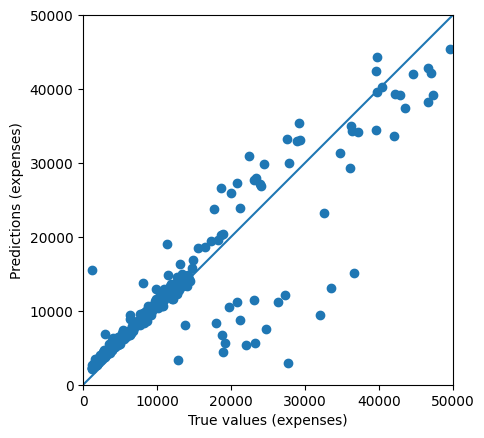

In [ ]:

# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = model.evaluate(test_ds, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_ds).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
